name            0
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64


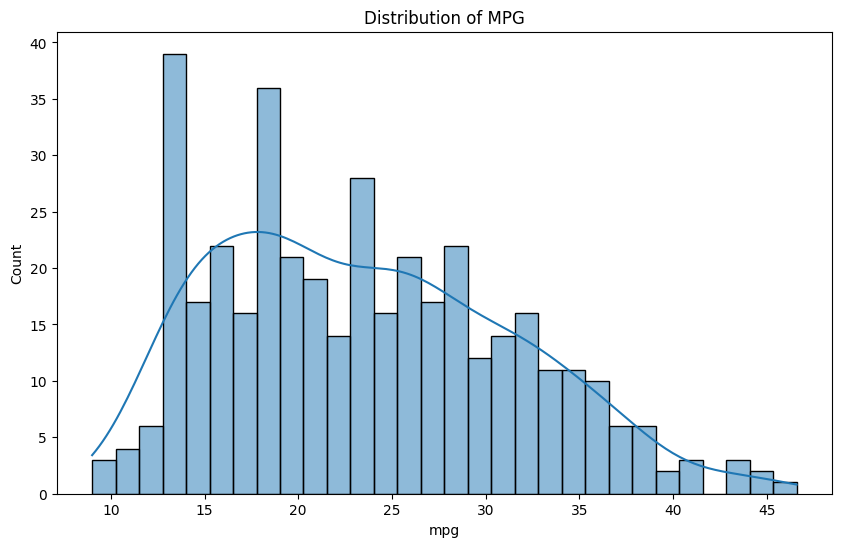

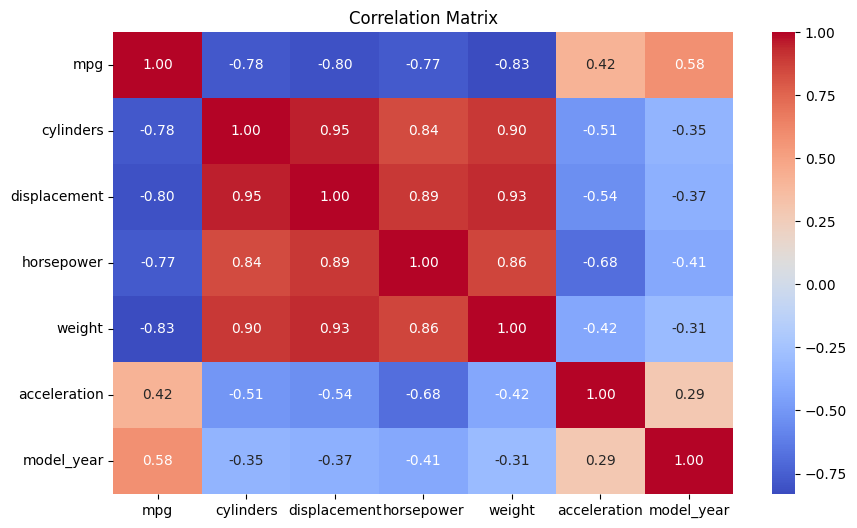

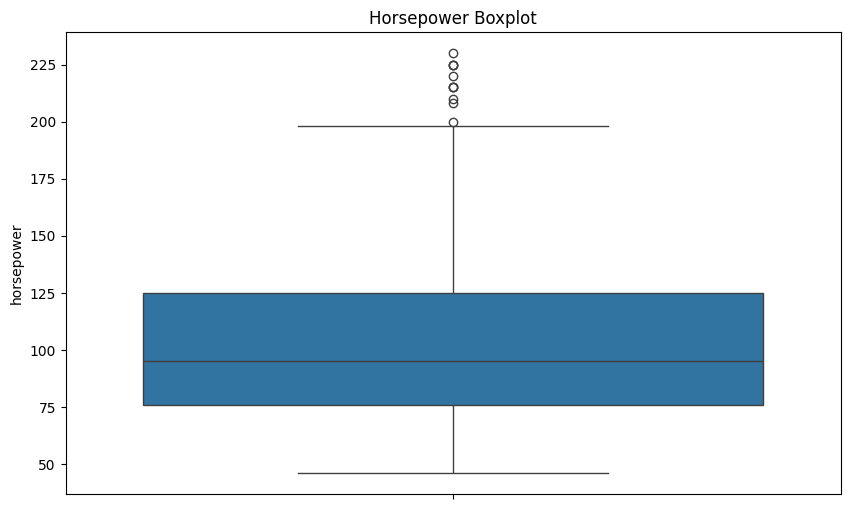

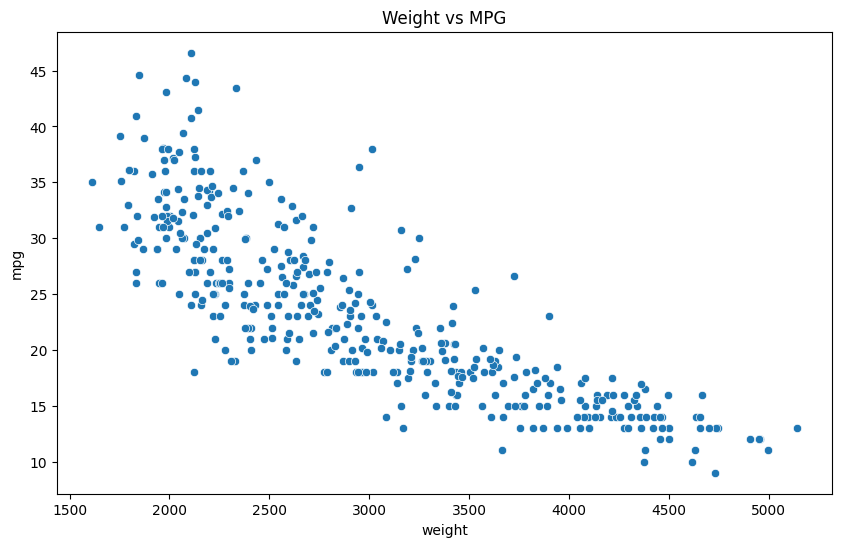

MSE: 4.94, R²: 0.91
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

C:\Users\wower\miniconda3\envs\Egetarb\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
from flask import Flask, request, jsonify


# ============================
# Steg 1: Datainsamling och Förberedelse
# ============================

# Läs in datasetet
df = pd.read_csv("Automobile.csv")
# Kolla efter saknade värden
print(df.isnull().sum())

# Hantera saknade värden genom att fylla med medelvärdet
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].mean())

# EDA Visualiseringar
plt.figure(figsize=(10, 6))
sns.histplot(df['mpg'], bins=30, kde=True)
plt.title('Distribution of MPG')
plt.show()

numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df['horsepower'])
plt.title('Horsepower Boxplot')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='weight', y='mpg')
plt.title('Weight vs MPG')
plt.show()

# ============================
# Steg 2: Datapreparation
# ============================
features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
X = df[features]
y = df['mpg']

# Standardisering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dela upp data i tränings- och testset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ============================
# Steg 3: Modellträning och Utvärdering
# ============================
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Gör prediktioner på testdata
y_pred = model.predict(X_test)

# Utvärdera modellen
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}, R²: {r2:.2f}')

# Exportera den tränade modellen
joblib.dump(model, 'automobile_mpg_model.pkl')

# ============================
# Steg 4: API-utveckling
# ============================
app = Flask(__name__)

# Ladda den exporterade modellen
model = joblib.load('automobile_mpg_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    features = np.array([data['cylinders'], 
                         data['displacement'], 
                         data['horsepower'], 
                         data['weight'], 
                         data['acceleration'], 
                         data['model_year']]).reshape(1, -1)
    
    # Gör en prediktion
    prediction = model.predict(features)
    
    return jsonify({'predicted_mpg': prediction[0]})

if __name__ == '__main__':
    app.run(debug=True)
